# Comparison to Boruta

comparison with Leshy, which is BorutaPy implementation with:

 - categorical features handling
 - plot method
 - catboost and lightGBM handling
 - SHAP and permutation importance
 - sample weight

The implementation is however quite close to the BorutaPy one. A PR has been opened on the official BorutaPy repo.


In [7]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sys import getsizeof, path

from boruta import BorutaPy

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

# plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
gc.enable()
gc.collect()

4

## Comparison

I'll just remove the collinear predictors since they are actually harmful for the ARFS, see the [Collinearity notebook](./Collinearity.ipynb)

In [4]:
cancer = load_data(name='cancer')
X, y = cancer.data, cancer.target

# basic feature selection
basic_fs_pipeline = Pipeline([
    ('missing', arfsfs.MissingValueThreshold(threshold=.05)),
    ('unique', arfsfs.UniqueValuesThreshold(threshold=1)),
    ('cardinality', arfsfs.CardinalityThreshold(threshold=1000)),
    ('collinearity', arfsfs.CollinearityThreshold(threshold=0.75))
])

X_filtered = basic_fs_pipeline.fit_transform(X=X, y=y)#  , collinearity__sample_weight=w,
X_filtered.head()

,mean texture,mean area,texture error,smoothness error,symmetry error,worst smoothness,random_num1,random_num2,genuine_num
0,10.38,1001.0,0.9053,0.006399,0.03003,0.1622,0.496714,0,-0.249340
1,17.77,1326.0,0.7339,0.005225,0.01389,0.1238,-0.138264,1,-0.044410
2,21.25,1203.0,0.7869,0.006150,0.02250,0.1444,0.647689,3,0.128395
3,20.38,386.1,1.1560,0.009110,0.05963,0.2098,1.523030,0,-0.079921
4,14.34,1297.0,0.7813,0.011490,0.01756,0.1374,-0.234153,0,-0.094302


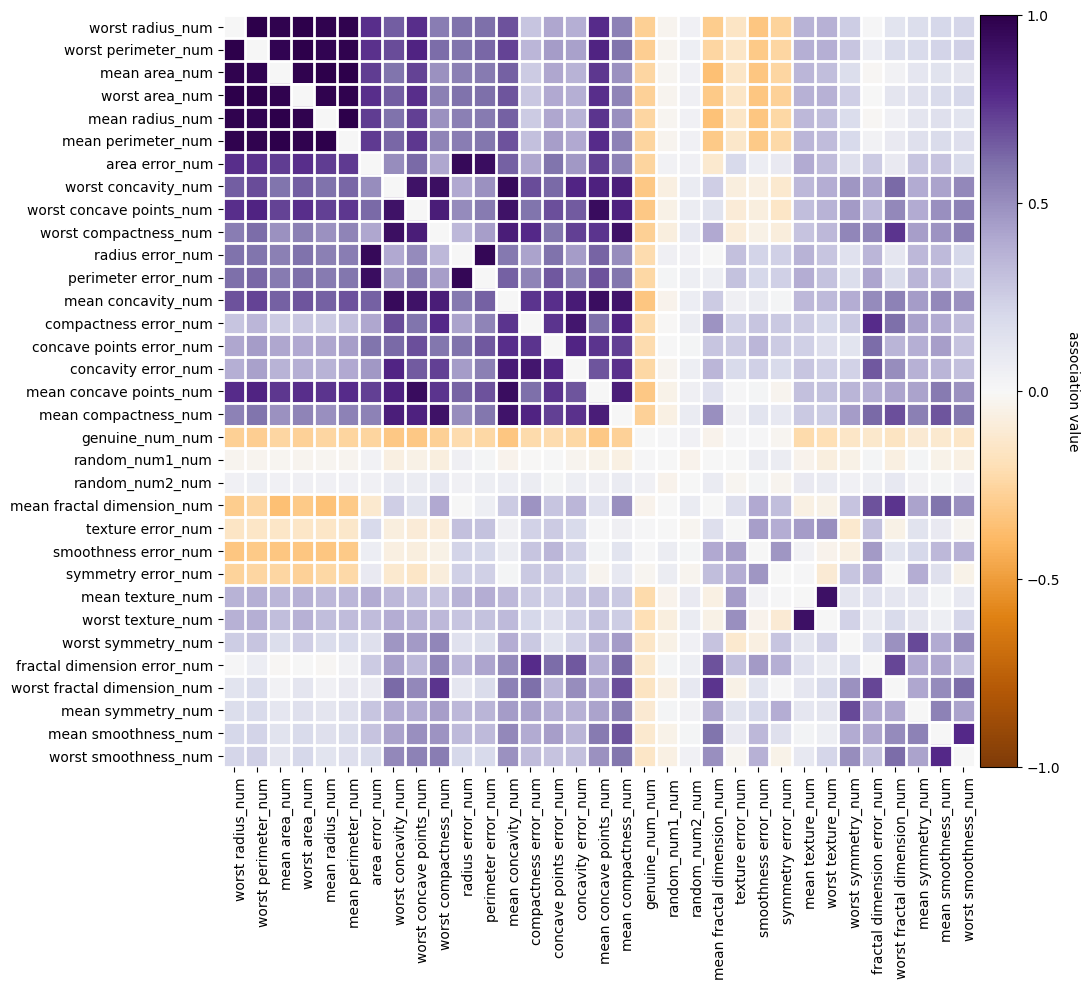

In [5]:
basic_fs_pipeline.named_steps['collinearity'].plot_association()

### BorutaPy

Boruta, in its "official" implementation uses gain/gini feature importance (which is known to be biased). Let's see what are the results on this data set

In [13]:
%%time

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
bp_feat_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=1)

# find all relevant features - 5 features should be selected
bp_feat_selector.fit(X_filtered.values, y.values)

# check selected features - first 5 features are selected
print("\n")
print(list(X_filtered.columns[bp_feat_selector.support_]))

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100


BorutaPy finished running.

Iteration: 	23 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	2


['mean texture', 'mean area', 'texture error', 'smoothness error', 'symmetry error', 'worst smoothness', 'genuine_num']
CPU times: total: 5.95 s
Wall time: 3.88 s


### Leshy

Let's compare to the official python implementation, using the same setting and the gini/gain feature importance. We should have the same results (btw, you can check the unit tests, BorutaPy is used as baseline).

Leshy iteration:  12%|█▏        | 12/100 [00:02<00:18,  4.66it/s]




Leshy finished running using native var. imp.

Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	2
All relevant predictors selected in 00:00:02.59
The selected features: ['mean texture' 'mean area' 'texture error' 'smoothness error'
 'symmetry error' 'worst smoothness' 'genuine_num']
The agnostic ranking: [1 1 1 1 1 1 2 3 1]
The naive ranking: ['mean area', 'mean texture', 'worst smoothness', 'genuine_num', 'smoothness error', 'texture error', 'symmetry error', 'random_num1', 'random_num2']


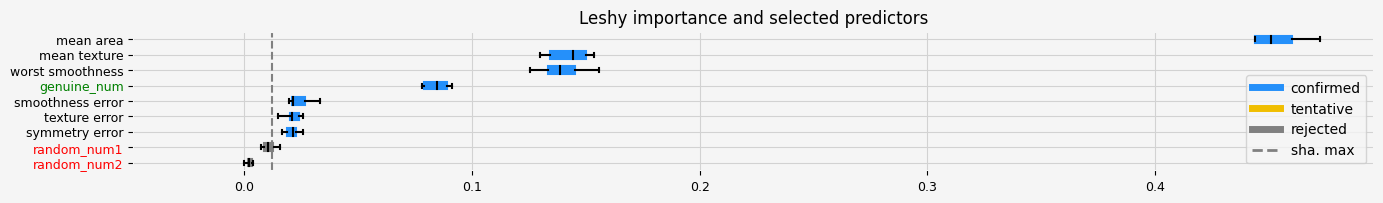

CPU times: total: 3.52 s
Wall time: 2.84 s


In [16]:
%%time
# Leshy, all the predictors, no-preprocessing
model = clone(rf)

leshy_feat_selector = arfsgroot.Leshy(rf, n_estimators='auto', verbose=1, max_iter=100, random_state=1, importance='native')
leshy_feat_selector.fit(X_filtered, y, sample_weight=None)
print(f"The selected features: {leshy_feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {leshy_feat_selector.ranking_}")
print(f"The naive ranking: {leshy_feat_selector.ranking_absolutes_}")
fig = leshy_feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()


### Same Results?

In [17]:
def check_list_equal(L1, L2):
    return len(L1) == len(L2) and sorted(L1) == sorted(L2)

In [18]:
check_list_equal(leshy_feat_selector.get_feature_names_out(), list(X_filtered.columns[bp_feat_selector.support_]))

True

## BorutaShap with native importance

BorutaShap, is an alternative implementation (heavy re-writting and new material) of Boruta with Shap feature importance. Let's see what are the results on this data set

In [20]:
%%time

from BorutaShap import BorutaShap
from arfs.preprocessing import OrdinalEncoderPandas

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define BorutaShap feature selection method (doesn't convert automatically cat feature)
X_encoded = OrdinalEncoderPandas().fit_transform(X=X_filtered)
bs_feat_selector = BorutaShap(model=model, importance_measure='gini', classification=True)

# find all relevant features - 5 features should be selected
bs_feat_selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
bs_feat_selector.plot(X_size=12, figsize=(8,6), y_scale='log', which_features='all')

AttributeError: Model must contain the feature_importances_ method to use Gini try Shap instead

The `hasattr` is called before fitting so `feature_importances_` is not found. Let's use the default, which is also a random forest

  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['mean texture', 'smoothness error', 'genuine_num', 'texture error', 'worst smoothness', 'symmetry error', 'mean area']
2 attributes confirmed unimportant: ['random_num1', 'random_num2']
0 tentative attributes remains: []


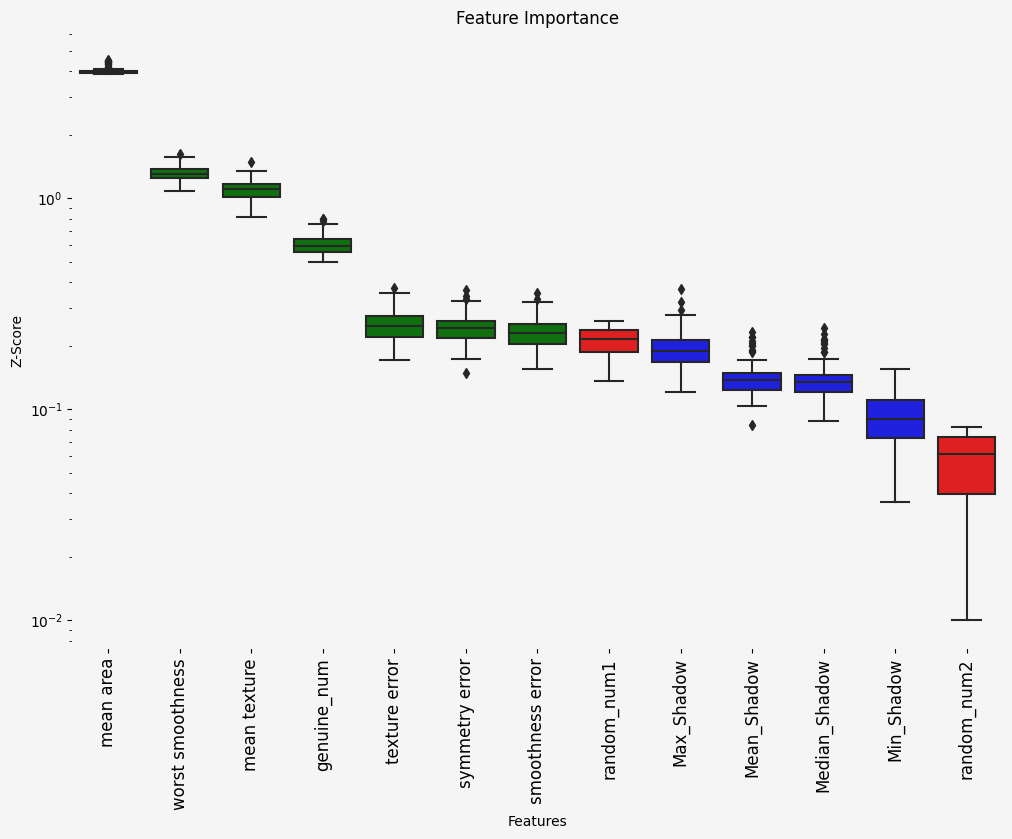

CPU times: total: 19.4 s
Wall time: 19.4 s


In [22]:
%%time

from BorutaShap import BorutaShap

bs_feat_selector = BorutaShap(importance_measure='gini', classification=True)

# find all relevant features - 5 features should be selected
bs_feat_selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
bs_feat_selector.plot(X_size=12, figsize=(12,8), y_scale='log', which_features='all')

### Comparison with Boruta

In [23]:
check_list_equal(list(X_filtered.columns[bp_feat_selector.support_]), list(bs_feat_selector.accepted))

True